The purpose of this notebook is to quickly model how the water potential varies up the trunk, assumig a single non-branching trunk.

In [1]:
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_parameters_from_conductance_loss

import numpy as np
from matplotlib import pyplot as plt
import copy as cp

# Model setup
First let us set up the properties of the system and the different arrays needed to hold the data.

In [2]:
p50 = -3.
p88 = -4.
k_max = 1.

# Calcualte the shape and scale parameters for the Weibull distribution
k_max, shape, scale = cumulative_Weibull_distribution_parameters_from_conductance_loss(k_max, p50, p88, 0.5, 0.88)

N_points = 1000

# Set up an array to hold the height of each point
hights = np.linspace(0, 100, N_points + 2)


# Model run
The transpiration across any given section must be constant through the system.

$$
E_{n, n+1} = k_{n, n+1} (\psi_{n+1} - \psi_{n})
$$

For suficently small $\Delta \psi$ we can approximate the conductance $k_{n, n+1}$ as the conductance at the mean of the two water potentials.

$$
k_{n, n+1} = k(\text{mean}(\psi_{n}, \psi_{n+1}))
$$

Given that the transpiration is equal for all sections we can write the following;

$$
k_{n, n+1}( \psi_{n+1} - \psi_{n}) = k_{n-1, n}( \psi_{n} - \psi_{n-1})
$$

Re-arranging the equation we get a value for the water potential at point $n$;

$$
\psi_{n} = \frac{\psi_{n-1}k_{n-1,n} + \psi_{n+1}k_{n,n+1}}{k_{n-1,n} + k_{n,n+1}}
$$

We can iteratively solve for the water potential and the conductance, holding the soil and lea water potentials at each end constant, until we reach equilibrium. This should give us the water potential at each point along the trunk.

In [3]:
def calc_height_dependencies(psi_root, psi_leaf, N_points, k_max, shape, scale, 
                             N_steps=1000000, tolerance=1e-8):
    
    psi_current = np.linspace(psi_root, psi_leaf, N_points + 2)

    psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
    k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
    
    E_current = k_current * (psi_current[1:] - psi_current[:-1])
    
    i = 0
    
    for i in range(N_steps):
        # Update the water potential at each point
        psi_current[1:-1] = (psi_current[:-2] * k_current[:-1] + psi_current[2:] * k_current[1:]) / (k_current[:-1] + k_current[1:])
        
        # Update the conductance between each point
        psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
        k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
        
        # Update the transpiration between each point
        E_current = k_current * (psi_current[1:] - psi_current[:-1])
        
        # Check for convergence
        if np.all(np.abs(E_current[0] - E_current[-1]) < tolerance):
            break
            
    
    print('Finished at step', i, 'of', N_steps)
    
    return psi_current, k_current, E_current

psi_leaf = -6.
psi_root = -0.1

psi, k, E = calc_height_dependencies(psi_root, 
                                                             psi_leaf, 
                                                             N_points, 
                                                             k_max, 
                                                             shape, 
                                                             scale)

Finished at step 999999 of 1000000


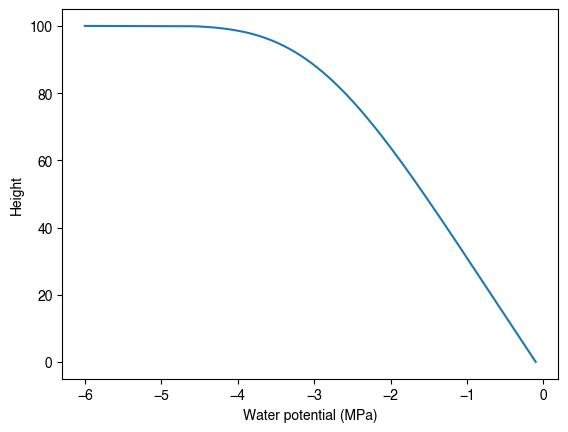

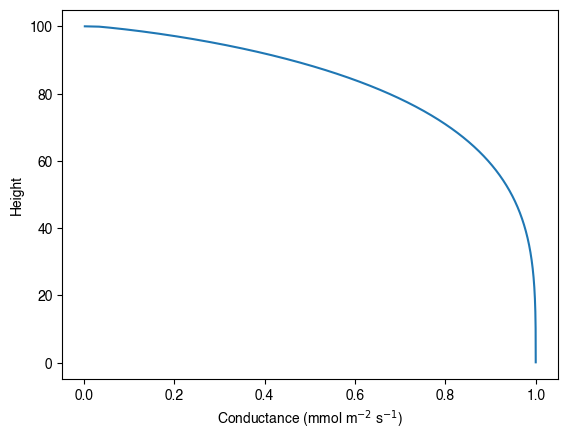

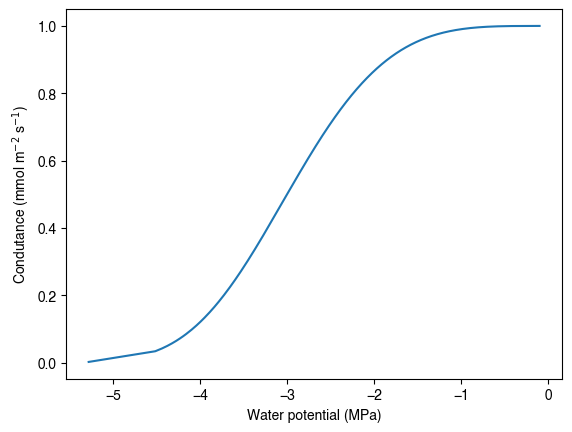

In [4]:
plt.plot(psi, hights)
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.show()

plt.plot(k, hights[1:])
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

'''
plt.plot(E, hights[1:])
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.show()
'''

plt.plot((psi[1:] + psi[:-1])/2, k)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

# Changing the maximum conductance
Since shortening the length of the xylem changes its conductance we need to check if this would change how the water potential varies up the trunk.

In [5]:
k_max = [1., 2., 3.]

psi_leaf = -6.
psi_root = -0.1

psi = []
k = []
E = []

for k_max_current in k_max:
    psi_current, k_current, E_current = calc_height_dependencies(psi_root, 
                                                                 psi_leaf, 
                                                                 N_points, 
                                                                 k_max_current, 
                                                                 shape, 
                                                                 scale)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


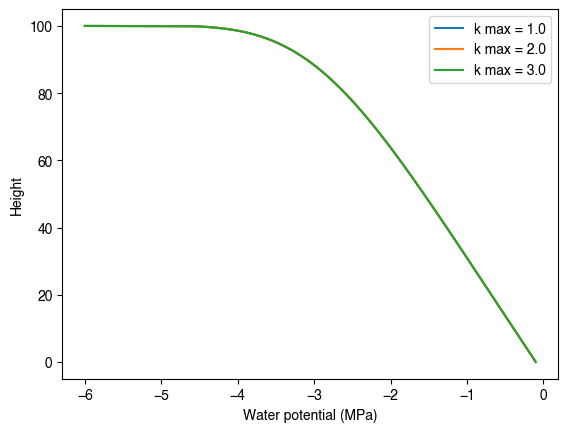

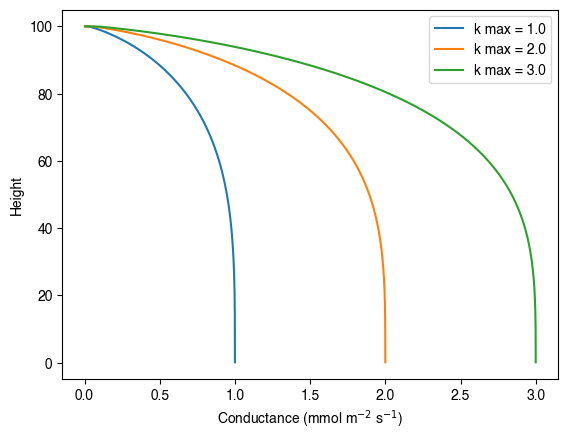

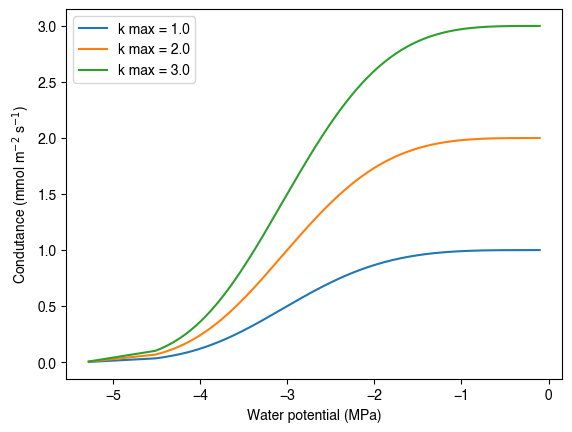

In [6]:
for i in range(len(psi)):
    plt.plot(psi[i], hights, label='k max = ' + str(k_max[i]))
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(k[i], hights[1:], label='k max = ' + str(k_max[i]))
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

'''
for i in range(len(E)):
    plt.plot(E[i], hights[1:], label='k max = ' + str(k_max[i]))
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()
'''

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='k max = ' + str(k_max[i]))
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

We can see that changing the maximum conductance doesn't impact the water potential as a function of height up the tree. Further it only impacts the magnitude of the transpiration rate hence we don't need to worry about it.

# Comparing different leaf water potentials
Let's compare the impact of the leaf water potential. The root zone water potential is set to -0.5 MPa.

In [7]:
psi_leaf = [-1., -2., -3., -4., -5., -6.]

k_max = 1.
psi_root = -0.5

psi = []
k = []
E = []

for psi_leaf_current in psi_leaf:
    psi_current, k_current, E_current = calc_height_dependencies(psi_root, 
                                                                 psi_leaf_current, 
                                                                 N_points, 
                                                                 k_max, 
                                                                 shape, 
                                                                 scale)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


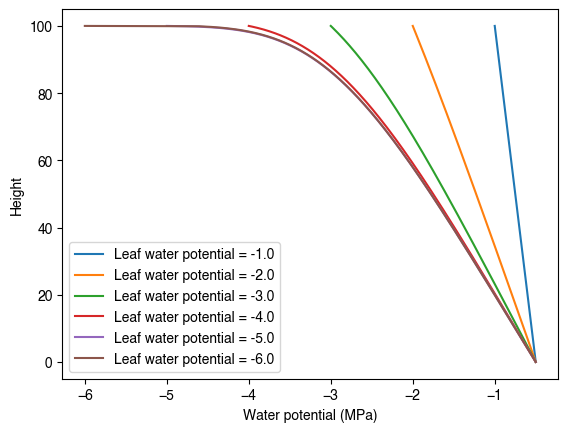

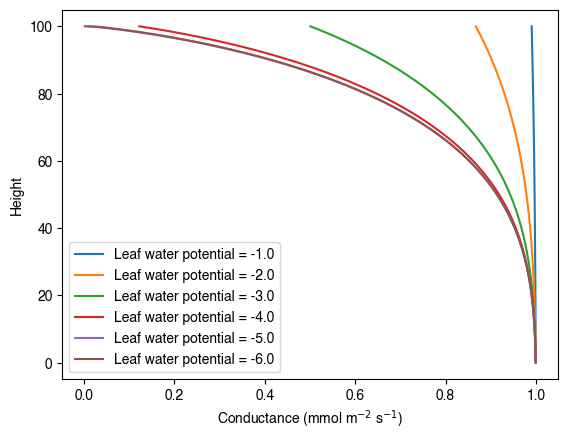

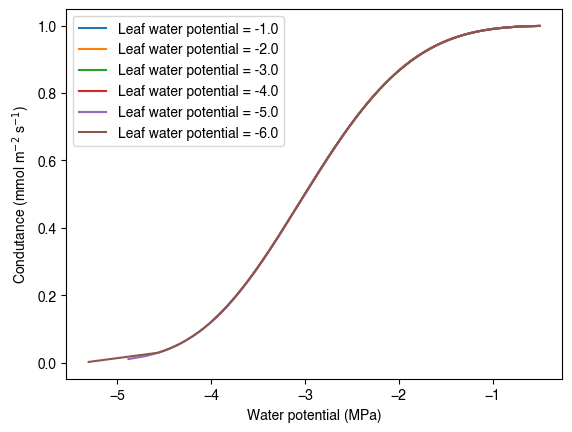

In [8]:
for i in range(len(psi)):
    plt.plot(psi[i], hights, label='Leaf water potential = ' + str(psi_leaf[i]))
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(k[i], hights[1:], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

'''
for i in range(len(E)):
    plt.plot(E[i], hights[1:], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()
'''

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

# Capping the conductance
To model xylem damage we can cap the conductance at each height to a previous minimum value.

In [9]:
def calc_height_dependencies_capped_k(psi_root, psi_leaf, N_points, k_max, shape, scale, k_cap,
                                      N_steps=1000000, tolerance=1e-8):
    
    psi_current = np.linspace(psi_root, psi_leaf, N_points + 2)

    psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
    k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
    
    E_current = k_current * (psi_current[1:] - psi_current[:-1])
    
    i = 0
    
    for i in range(N_steps):
        # Update the water potential at each point
        psi_current[1:-1] = (psi_current[:-2] * k_current[:-1] + psi_current[2:] * k_current[1:]) / (k_current[:-1] + k_current[1:])
        
        # Update the conductance between each point
        psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
        k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
        
        # Cap the conductance
        k_current = np.minimum(k_current, k_cap)
        
        # Calculate the transpiration between each point
        E_current = k_current * (psi_current[1:] - psi_current[:-1])
        
        # Check for convergence
        if np.all(np.abs(E_current[0] - E_current[-1]) < tolerance):
            break
            
    
    print('Finished at step', i, 'of', N_steps)
    
    return psi_current, k_current, E_current

## Varying leaf water potential
Here we want to see how varying the leaf water potential with the xylem damage model impacts the results. We set the previous minimum leaf and root water potentials to -3.0 MPa and -0.5 MPa respectively. For each calculation the root water potential is set equal to the previous minimum -0.5 MPa.

In [10]:
# Cap the conductance for each height as the value when the leaf and root water potentials are -3.0 MPa and -0.5 MPa respectively
psi_root = -0.5
psi_leaf = -3.0

psi_cap, k_cap, E_cap = calc_height_dependencies(psi_root, 
                                                 psi_leaf, 
                                                 N_points, 
                                                 k_max, 
                                                 shape, 
                                                 scale)

psi_leaf = [-1., -1.5, -2., -2.5, -3., -4., -5., -6.]

psi = []
k = []
E = []

for psi_leaf_current in psi_leaf:
    psi_current, k_current, E_current = calc_height_dependencies_capped_k(psi_root, 
                                                                          psi_leaf_current, 
                                                                          N_points, 
                                                                          k_max, 
                                                                          shape, 
                                                                          scale,
                                                                          k_cap)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


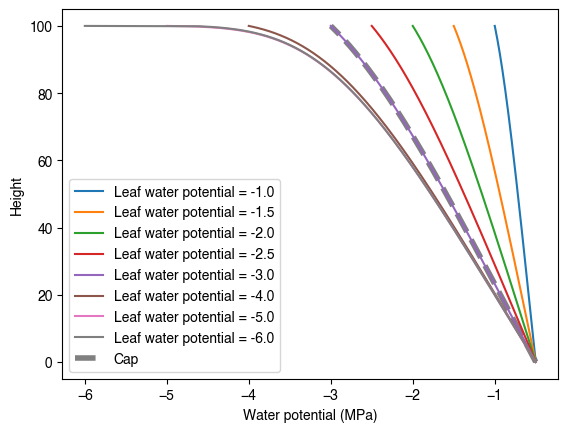

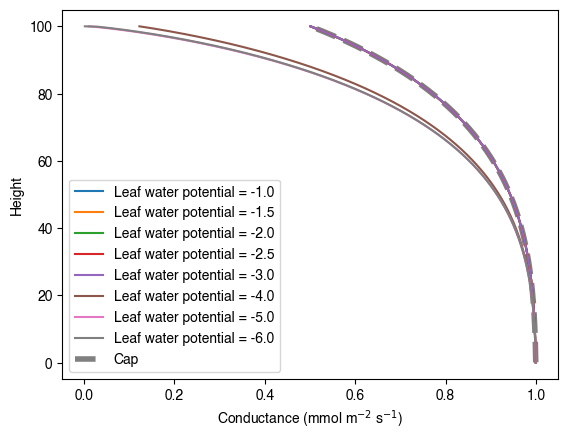

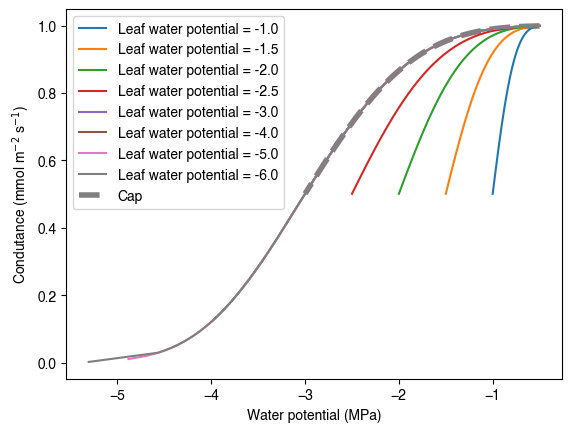

In [11]:
for i in range(len(psi)):
    plt.plot(psi[i], hights, label='Leaf water potential = ' + str(psi_leaf[i]))
plt.plot(psi_cap, hights, label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(k[i], hights[1:], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.plot(k_cap, hights[1:], label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

'''
for i in range(len(E)):
    plt.plot(E[i], hights[1:], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.plot(E_cap, hights[1:], label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()
'''

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.plot((psi_cap[1:]+psi_cap[:-1])/2, k_cap, label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

## Varying root water potential
Let's repeat the calculation above but vary the root water potential instead. The leaf water potential is set to -3.0 MPa.

In [ ]:
# Cap the conductance for each height as the value when the leaf water potential is -3.0 MPa and root water potential is -1.0 MPa
psi_root = -1.0
psi_leaf = -3.0

psi_cap, k_cap, E_cap = calc_height_dependencies(psi_root, 
                                                 psi_leaf, 
                                                 N_points, 
                                                 k_max, 
                                                 shape, 
                                                 scale)

psi_leaf = -3.0
psi_root = [-0., -0.2, -0.4, -0.6, -0.8, -1.0, -1.2, -1.4]

psi = []
k = []
E = []

for psi_root_current in psi_root:
    psi_current, k_current, E_current = calc_height_dependencies_capped_k(psi_root_current, 
                                                                          psi_leaf, 
                                                                          N_points, 
                                                                          k_max, 
                                                                          shape, 
                                                                          scale,
                                                                          k_cap)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


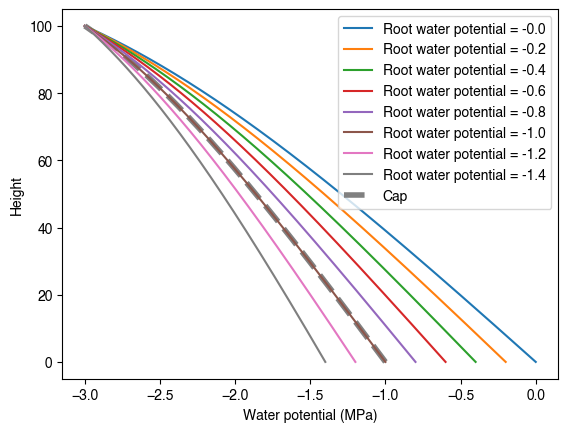

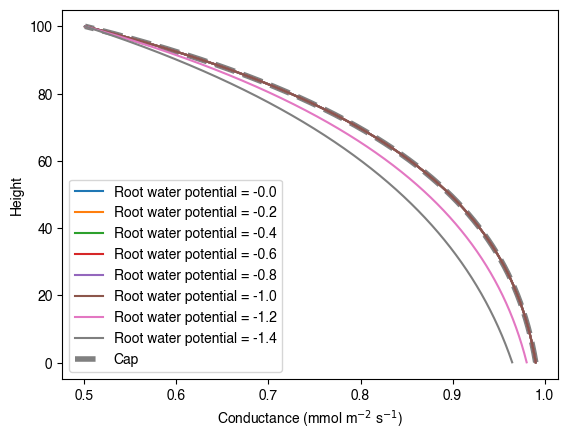

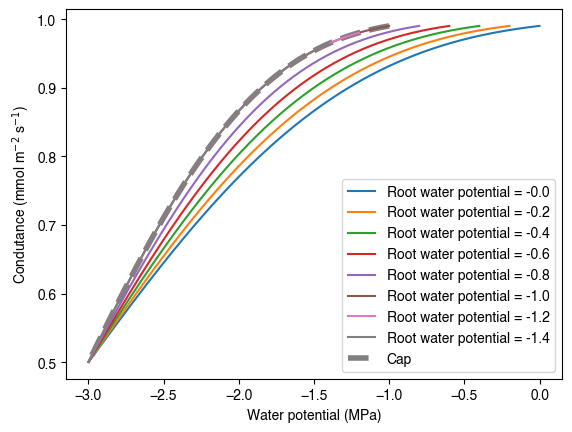

In [13]:
for i in range(len(psi)):
    plt.plot(psi[i], hights, label='Root water potential = ' + str(psi_root[i]))
plt.plot(psi_cap, hights, label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(k[i], hights[1:], label='Root water potential = ' + str(psi_root[i]))
plt.plot(k_cap, hights[1:], label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

'''
for i in range(len(E)):
    plt.plot(E[i], hights[1:], label='Root water potential = ' + str(psi_root[i]))
plt.plot(E_cap, hights[1:], label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()
'''

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='Root water potential = ' + str(psi_root[i]))
plt.plot((psi_cap[1:]+psi_cap[:-1])/2, k_cap, label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

## When both the root and leaf water potential don't match the previous minimums
So far, when varying the root and leaf water potentials, we have kept the fixed water potentials equal to that used when creating the conductance cap. Let's see what happens when they don't match. There are four cases to consider;

|                          | $\psi_l < \psi_{l, cap}$ | $\psi_{l, cap} < \psi_l$ |
|:-------------------------|:------------------------:|:------------------------:|
| $\psi_r < \psi_{r, cap}$ |            1             |            2             |
| $\psi_{r, cap} < \psi_r$ |            3             |            4             |


In [14]:
# Cap the conductance for each height as the value when the leaf water potential is -3.0 MPa and root water potential is -1.0 MPa
psi_root = -1.0
psi_leaf = -3.0

psi_cap, k_cap, E_cap = calc_height_dependencies(psi_root, 
                                                 psi_leaf, 
                                                 N_points, 
                                                 k_max, 
                                                 shape, 
                                                 scale)

psi_leaf = [-2.5, -3.5, -2.5, -3.5]
psi_root = [-0.5, -0.5, -1.5, -1.5]

psi = []
k = []
E = []

for i in range(len(psi_leaf)):
    psi_current, k_current, E_current = calc_height_dependencies_capped_k(psi_root[i], 
                                                                          psi_leaf[i], 
                                                                          N_points, 
                                                                          k_max, 
                                                                          shape, 
                                                                          scale,
                                                                          k_cap)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)

Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


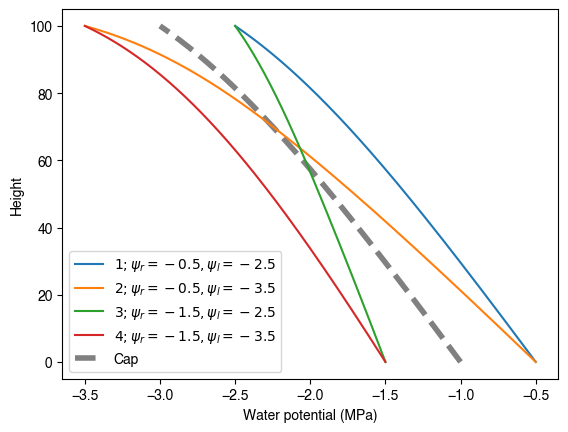

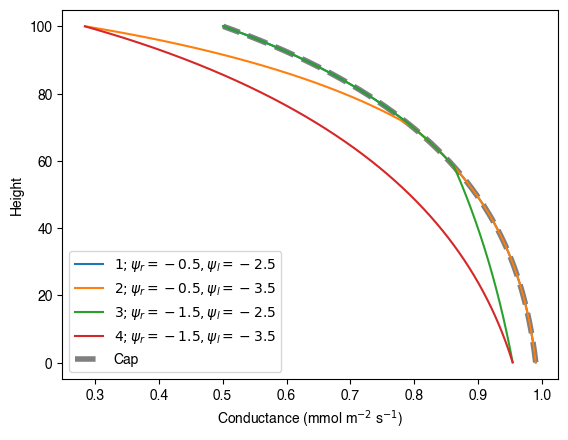

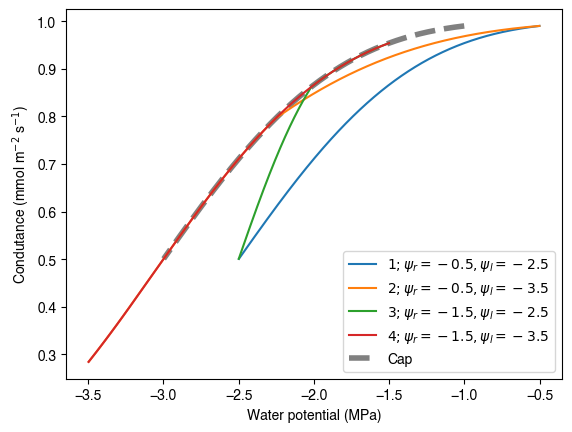

In [18]:
for i in range(len(psi)):
    plt.plot(psi[i], hights, label='$' + str(i+1) + '; \psi_r = ' + str(psi_root[i]) + ', \psi_l = ' + str(psi_leaf[i]) + '$')
plt.plot(psi_cap, hights, label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(k[i], hights[1:], label='$' + str(i+1) + '; \psi_r = ' + str(psi_root[i]) + ', \psi_l = ' + str(psi_leaf[i]) + '$')
plt.plot(k_cap, hights[1:], label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

'''
for i in range(len(E)):
    plt.plot(E[i], hights[1:], label='$' + str(i+1) + '; \psi_r = ' + str(psi_root[i]) + ', \psi_l = ' + str(psi_leaf[i]) + '$')
plt.plot(E_cap, hights[1:], label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()
'''

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='$' + str(i+1) + '; \psi_r = ' + str(psi_root[i]) + ', \psi_l = ' + str(psi_leaf[i]) + '$')
plt.plot((psi_cap[1:]+psi_cap[:-1])/2, k_cap, label='Cap', linestyle='--', color='grey', linewidth=4, zorder=0)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()